####  209 pt 2
##### Question posed:

Can a random forest regression model predict the average daily amount charged (TotalCharge) to a patient during their stay?
- Numeric dependent variable


In [3]:
# Set up of notebook

import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import metrics
from scipy import stats
from scipy.stats.mstats import winsorize

# from functions import clean_columns, univariate, winz_outliers # Personal functions

%matplotlib inline

In [4]:
#Import data
med_df = pd.read_csv('medical_clean.csv')
med_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

In [5]:
## Find duplicates
print(med_df.duplicated().value_counts()) # this gives a count of unique values (this case is true/false)
print(med_df.duplicated().sum()) # This gives a count of the nymber of duplicates(counting the true)

False    10000
Name: count, dtype: int64
0


In [6]:
#Count number of missing values by columns
med_df.isnull().sum() 

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

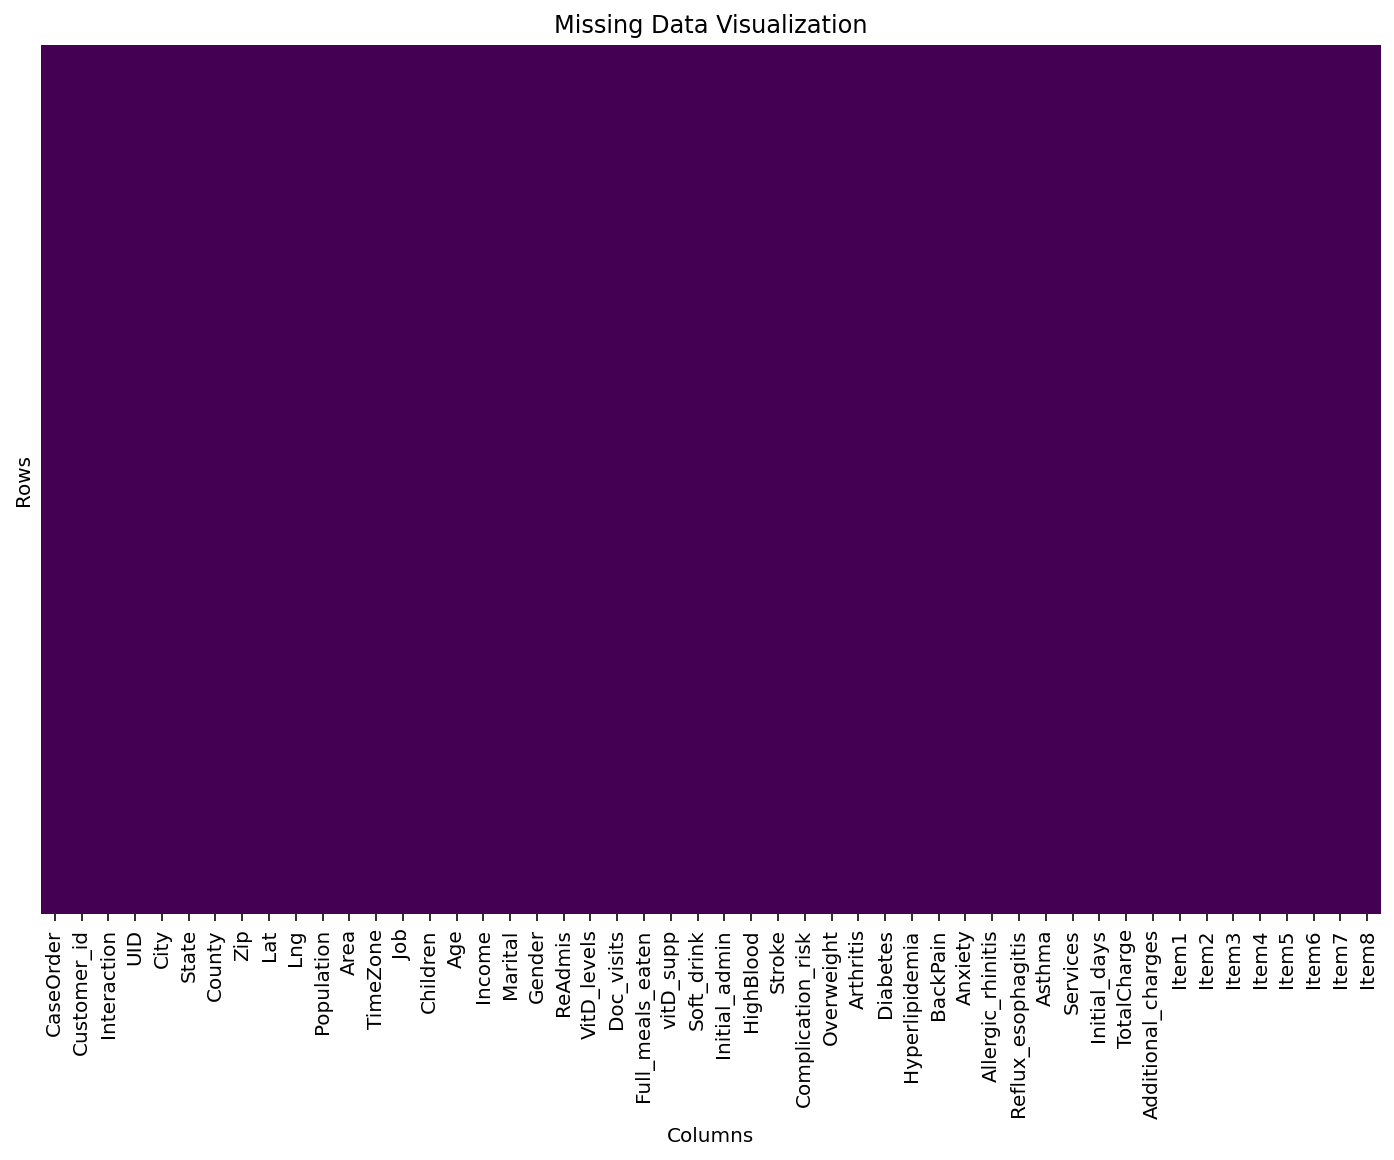

In [7]:
## Create Visualizations of the missing value

plt.figure(figsize=(12, 8))  # Adjust the figure size as necessary

# Create a heatmap to visualize missing data (null values)
# Set cbar=False to hide the color bar and add column names (xticklabels) for clarity
sns.heatmap(med_df.isnull(), cbar=False, cmap='viridis', yticklabels=False, xticklabels=med_df.columns)
plt.xticks(rotation=90)  # Rotate column names for better readability

plt.title('Missing Data Visualization')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

### Rename the data set
I do this on all data sets so that I know I have checked for duplicates and NAs

In [8]:
#Rename dataset
clean_df = med_df.copy()

#Explore the data
clean_df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


In [9]:
#Explore summary statistiscs on a data set
clean_df.describe()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,50159.323900,38.751099,-91.243080,9965.253800,2.097200,53.511700,40490.495160,17.964262,5.012200,...,5312.172769,12934.528587,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,2886.89568,27469.588208,5.403085,15.205998,14824.758614,2.163659,20.638538,28521.153293,2.017231,1.045734,...,2180.393838,6542.601544,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,1.00000,610.000000,17.967190,-174.209700,0.000000,0.000000,18.000000,154.080000,9.806483,1.000000,...,1938.312067,3125.703000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2500.75000,27592.000000,35.255120,-97.352982,694.750000,0.000000,36.000000,19598.775000,16.626439,4.000000,...,3179.374015,7986.487755,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,5000.50000,50207.000000,39.419355,-88.397230,2769.000000,1.000000,53.000000,33768.420000,17.951122,5.000000,...,5213.952000,11573.977735,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,7500.25000,72411.750000,42.044175,-80.438050,13945.000000,3.000000,71.000000,54296.402500,19.347963,6.000000,...,7459.699750,15626.490000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,10000.00000,99929.000000,70.560990,-65.290170,122814.000000,10.000000,89.000000,207249.100000,26.394449,9.000000,...,9180.728000,30566.070000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [10]:
# Clean the data set columns using created function based on tresholds
#missing_threshold = 0.95, unique_threshold = 0.95, only 1 value in a column --> removes

#Function for cleaning columns
def clean_columns(df, columns =[], missing_threshold = 0.95, unique_threshold = 0.95, messages = True):
    
    if len(columns) == 0:
        columns = df.columns #this lets the columns be blank and every columns will be cleaned
    
    for col in columns:
        if col in df.columns:
            missing = df[col].isna().sum()
            unique = df[col].nunique()
            rows = df.shape[0]  
            
            if missing / rows >= missing_threshold:
                if messages: print(f"To many missing values with ({missing} out of {rows}, {round((missing / rows) * 100, 2)}%) for {col}, removed")
                df.drop(columns =[col], inplace = True)
            # For non-numeric columns, check if there are too many unique values
            if not pd.api.types.is_numeric_dtype(df[col]) and (unique / rows >= unique_threshold):
                if messages: 
                    print(f"Too many unique values with ({unique} out of {rows}, {round((unique / rows) * 100, 2)}%) for {col}, removed")
                df.drop(columns=[col], inplace=True)
                continue
            elif unique == 1:
                if messages: print(f"Only one value in ({df[col].unique()[0]} for {col}, removed")
                df.drop(columns =[col], inplace = True)
         
        else:
            if messages: print(f"The column variable \"{col}\" doesnt exist as spelled in the DataFrame provided")
     
    return df

clean_columns(clean_df)

Too many unique values with (10000 out of 10000, 100.0%) for Customer_id, removed
Too many unique values with (10000 out of 10000, 100.0%) for Interaction, removed
Too many unique values with (10000 out of 10000, 100.0%) for UID, removed


,CaseOrder,City,State,County,Zip,Lat,Lng,Population,Area,TimeZone,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,Eva,AL,Morgan,35621,34.34960,-86.72508,2951,Suburban,America/Chicago,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Marianna,FL,Jackson,32446,30.84513,-85.22907,11303,Urban,America/Chicago,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,17125,Suburban,America/Chicago,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,New Richland,MN,Waseca,56072,43.89744,-93.51479,2162,Suburban,America/Chicago,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,West Point,VA,King William,23181,37.59894,-76.88958,5287,Rural,America/New_York,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Norlina,NC,Warren,27563,36.42886,-78.23716,4762,Urban,America/New_York,...,6850.942000,8927.642000,3,2,2,3,4,3,4,2
9996,9997,Milmay,NJ,Atlantic,8340,39.43609,-74.87302,1251,Urban,America/New_York,...,7741.690000,28507.150000,3,3,4,2,5,3,4,4
9997,9998,Southside,TN,Montgomery,37171,36.36655,-87.29988,532,Rural,America/Chicago,...,8276.481000,15281.210000,3,3,3,4,4,2,3,2
9998,9999,Quinn,SD,Pennington,57775,44.10354,-102.01590,271,Rural,America/Denver,...,7644.483000,7781.678000,5,5,3,4,4,3,4,3


In [11]:
#Verify / Re-examine
clean_df.head()

,CaseOrder,City,State,County,Zip,Lat,Lng,Population,Area,TimeZone,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,Eva,AL,Morgan,35621,34.34960,-86.72508,2951,Suburban,America/Chicago,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Marianna,FL,Jackson,32446,30.84513,-85.22907,11303,Urban,America/Chicago,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,17125,Suburban,America/Chicago,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,New Richland,MN,Waseca,56072,43.89744,-93.51479,2162,Suburban,America/Chicago,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,West Point,VA,King William,23181,37.59894,-76.88958,5287,Rural,America/New_York,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


In [12]:
# Remove the index column
clean_df = clean_df.iloc[:, 1:]
#Verify
clean_df.head()

,City,State,County,Zip,Lat,Lng,Population,Area,TimeZone,Job,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,Eva,AL,Morgan,35621,34.34960,-86.72508,2951,Suburban,America/Chicago,"Psychologist, sport and exercise",...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,Marianna,FL,Jackson,32446,30.84513,-85.22907,11303,Urban,America/Chicago,Community development worker,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,17125,Suburban,America/Chicago,Chief Executive Officer,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,New Richland,MN,Waseca,56072,43.89744,-93.51479,2162,Suburban,America/Chicago,Early years teacher,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,West Point,VA,King William,23181,37.59894,-76.88958,5287,Rural,America/New_York,Health promotion specialist,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


In [13]:
def univariate(df, plot=False):
    stats = []
    
    for col in df.columns:
        col_data = df[col].dropna()  # Drop NA early to avoid repeated calculation
        dtype = col_data.dtype
        desc = col_data.describe() if pd.api.types.is_numeric_dtype(col_data) else None
        
        stats_row = {
            "Variable": col,
            "Type": dtype,
            "Count": desc['count'] if desc is not None else col_data.count(),
            "Missing": df[col].isna().sum(),
            "Unique": col_data.nunique(),
            "Mode": col_data.mode().iloc[0] if not col_data.mode().empty else None
        }

        if pd.api.types.is_numeric_dtype(col_data):
            stats_row.update({
                "Min": desc['min'],
                "Q1": desc['25%'],
                "Median": desc['50%'],
                "Q3": desc['75%'],
                "Max": desc['max'],
                "Mean": desc['mean'],
                "Std": desc['std'],
                "Skew": col_data.skew(),
                "Kurt": col_data.kurt()
            })
            if plot:
                sns.histplot(col_data, kde=True)
                plt.title(f'Histogram of {col}')
                plt.show()
        else:
            stats_row.update({"Min": "-", "Q1": "-", "Median": "-", "Q3": "-", "Max": "-", "Mean": "-", "Std": "-", "Skew": "-", "Kurt": "-"})
            if plot:
                sns.countplot(x=col_data, data=df)
                plt.title(f'Count Plot of {col}')
                plt.show()

        stats.append(stats_row)

    output_df = pd.DataFrame(stats)
    output_df.set_index("Variable", inplace=True)
    return output_df


In [14]:
univariate(clean_df)  # (plot = True) # takes a lot of memory for all plots

,Type,Count,Missing,Unique,Mode,Min,Q1,Median,Q3,Max,Mean,Std,Skew,Kurt
Variable,,,,,,,,,,,,,,
City,object,10000.0,0,6072,Houston,-,-,-,-,-,-,-,-,-
State,object,10000.0,0,52,TX,-,-,-,-,-,-,-,-,-
County,object,10000.0,0,1607,Jefferson,-,-,-,-,-,-,-,-,-
Zip,int64,10000.0,0,8612,24136,610.0,27592.0,50207.0,72411.75,99929.0,50159.3239,27469.588208,0.022813,-1.065366
Lat,float64,10000.0,0,8588,28.51879,17.96719,35.25512,39.419355,42.044175,70.56099,38.751099,5.403085,0.008565,2.684186
Lng,float64,10000.0,0,8725,-97.76466,-174.2097,-97.352982,-88.39723,-80.43805,-65.29017,-91.24308,15.205998,-1.258973,2.3167
Population,int64,10000.0,0,5951,0,0.0,694.75,2769.0,13945.0,122814.0,9965.2538,14824.758614,2.229959,5.880913
Area,object,10000.0,0,3,Rural,-,-,-,-,-,-,-,-,-
TimeZone,object,10000.0,0,26,America/New_York,-,-,-,-,-,-,-,-,-


In [15]:
## Choose variables to narrow down
# TotalCharge, Population, Children, Age, Income, VitD_levels, Doc_visits, Full_meals_eaten, vitD_supp, Initial_days, Additional_charges, Gender, Initial_admin, Complication_risk, HighBlood, Diabetes, Hyperlipidemia, Services

rfr_data = clean_df[[
    "TotalCharge", "Population", "Children", "Age", "Income",
    "VitD_levels", "Doc_visits", "Full_meals_eaten", "vitD_supp",
    "Initial_days", "Additional_charges", "Gender", "Initial_admin",
    "Complication_risk", "HighBlood", "Diabetes", "Hyperlipidemia", "Services"
]].copy()
#Verify new data set
rfr_data.head()

,TotalCharge,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,Additional_charges,Gender,Initial_admin,Complication_risk,HighBlood,Diabetes,Hyperlipidemia,Services
0,3726.702860,2951,1,53,86575.93,19.141466,6,0,0,10.585770,17939.403420,Male,Emergency Admission,Medium,Yes,Yes,No,Blood Work
1,4193.190458,11303,3,51,46805.99,18.940352,4,2,1,15.129562,17612.998120,Female,Emergency Admission,High,Yes,No,No,Intravenous
2,2434.234222,17125,3,53,14370.14,18.057507,4,1,0,4.772177,17505.192460,Female,Elective Admission,Medium,Yes,Yes,No,Blood Work
3,2127.830423,2162,0,78,39741.49,16.576858,4,1,0,1.714879,12993.437350,Male,Elective Admission,Medium,No,No,No,Blood Work
4,2113.073274,5287,1,22,1209.56,17.439069,5,0,2,1.254807,3716.525786,Female,Elective Admission,Low,No,No,Yes,CT Scan


In [16]:
## Remove spaces in catagory names within columns
# To replace spaces with underscores in specific columns

for col in rfr_data.columns:
     if not pd.api.types.is_numeric_dtype(rfr_data[col]):
        rfr_data[col] = rfr_data[col].str.replace(" ", "_", regex = False) 
        
##Clean White Space and make all lower case
rfr_data.columns = rfr_data.columns.str.lower().str.strip()       

#round values to 2 decimal points
rfr_data = rfr_data.round(2)

#Verify space removal/ replacement
rfr_data.head()

,totalcharge,population,children,age,income,vitd_levels,doc_visits,full_meals_eaten,vitd_supp,initial_days,additional_charges,gender,initial_admin,complication_risk,highblood,diabetes,hyperlipidemia,services
0,3726.70,2951,1,53,86575.93,19.14,6,0,0,10.59,17939.40,Male,Emergency_Admission,Medium,Yes,Yes,No,Blood_Work
1,4193.19,11303,3,51,46805.99,18.94,4,2,1,15.13,17613.00,Female,Emergency_Admission,High,Yes,No,No,Intravenous
2,2434.23,17125,3,53,14370.14,18.06,4,1,0,4.77,17505.19,Female,Elective_Admission,Medium,Yes,Yes,No,Blood_Work
3,2127.83,2162,0,78,39741.49,16.58,4,1,0,1.71,12993.44,Male,Elective_Admission,Medium,No,No,No,Blood_Work
4,2113.07,5287,1,22,1209.56,17.44,5,0,2,1.25,3716.53,Female,Elective_Admission,Low,No,No,Yes,CT_Scan


In [17]:
## Detect and clean outliers

##Function for Winsorization of outliers, using IQR
#https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0
def winz_outliers(df):
    
    print("Outlier Analysis Report")
    print("=" * 50)  # Print a separator line for visual clarity
    
    for col in df:
        if pd.api.types.is_numeric_dtype(df[col]): 
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
            outlier_count = outliers.sum()
            
            if outlier_count > 0:
                outer_fence = 3 * IQR
                outer_fence_low = Q1 - outer_fence
                outer_fence_up = Q3 + outer_fence
                
                # Consolidating the print statements for each column
                print(f"\nColumn: {col}")
                print(f"Number of Outliers: {outlier_count}")
                print(f"Lower Outer Fence: {round(outer_fence_low, 2)}")
                print(f"Upper Outer Fence: {round(outer_fence_up, 2)}")

    print("=" * 50)  # End with a separator line for visual clarity


winz_outliers(rfr_data)

Outlier Analysis Report

Column: population
Number of Outliers: 855
Lower Outer Fence: -39056.0
Upper Outer Fence: 53695.75

Column: children
Number of Outliers: 411
Lower Outer Fence: -9.0
Upper Outer Fence: 12.0

Column: income
Number of Outliers: 326
Lower Outer Fence: -84494.11
Upper Outer Fence: 158389.28

Column: vitd_levels
Number of Outliers: 60
Lower Outer Fence: 8.46
Upper Outer Fence: 27.52

Column: full_meals_eaten
Number of Outliers: 8
Lower Outer Fence: -6.0
Upper Outer Fence: 8.0

Column: vitd_supp
Number of Outliers: 70
Lower Outer Fence: -3.0
Upper Outer Fence: 4.0

Column: additional_charges
Number of Outliers: 424
Lower Outer Fence: -14933.53
Upper Outer Fence: 38546.5


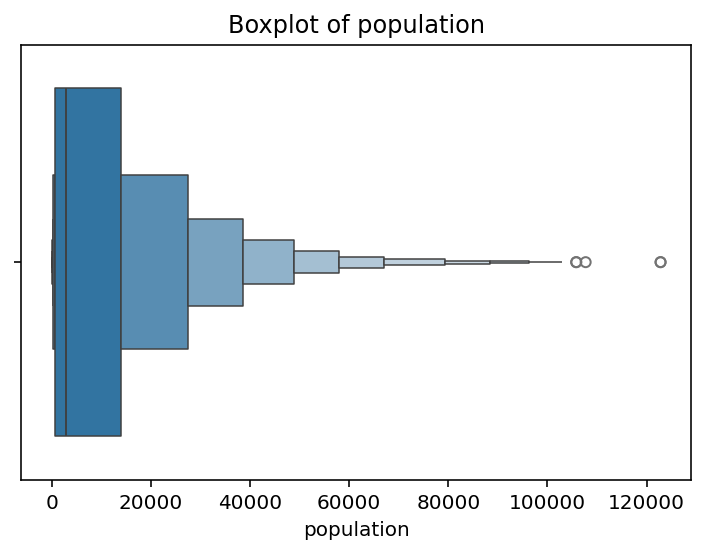

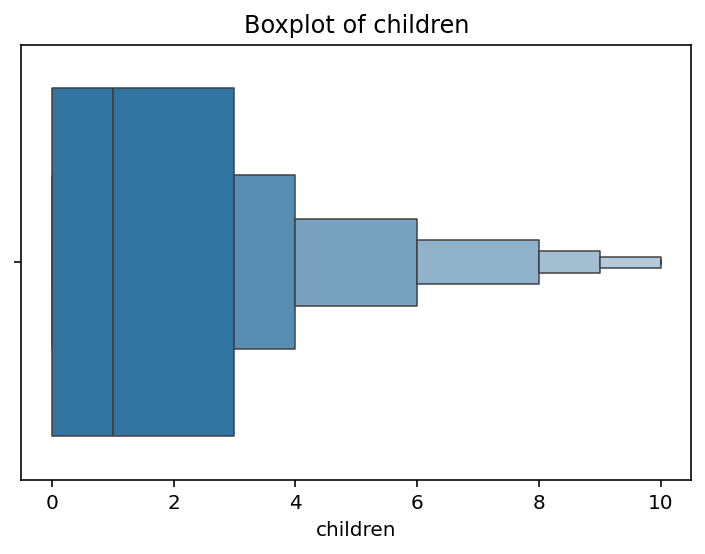

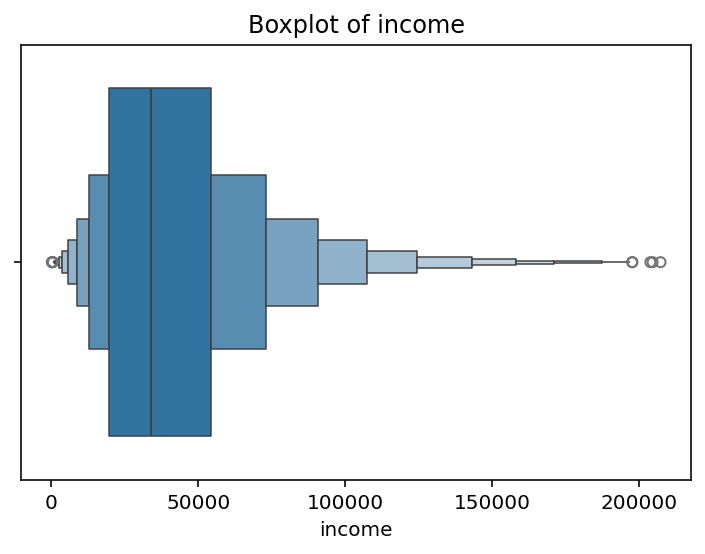

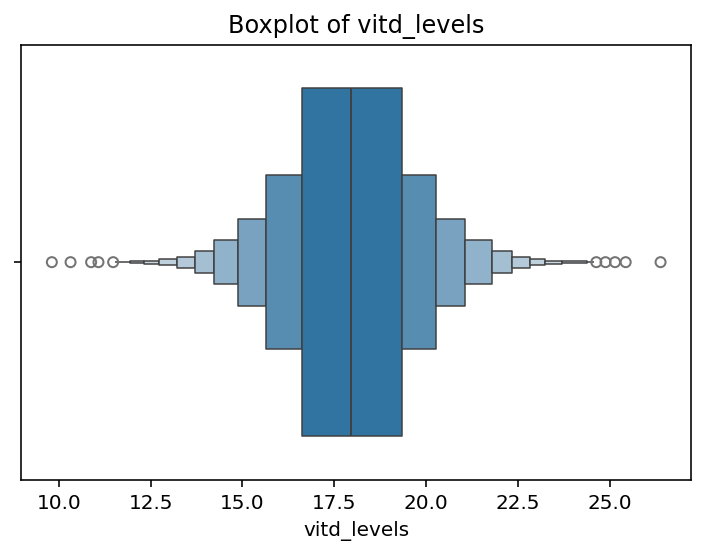

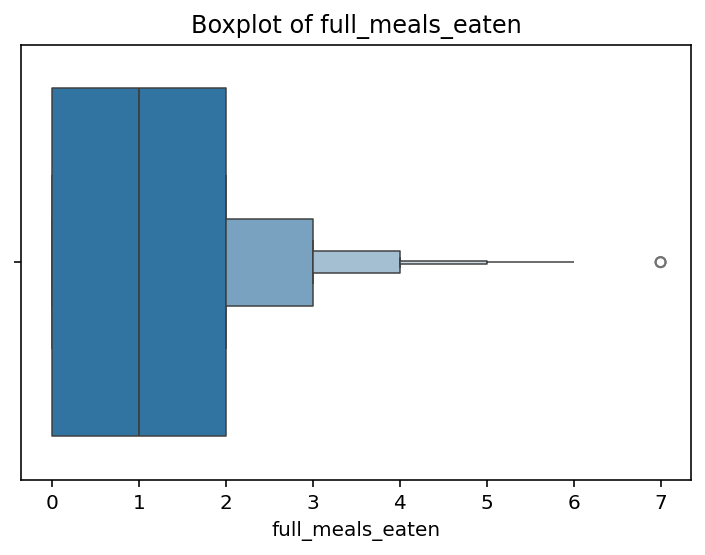

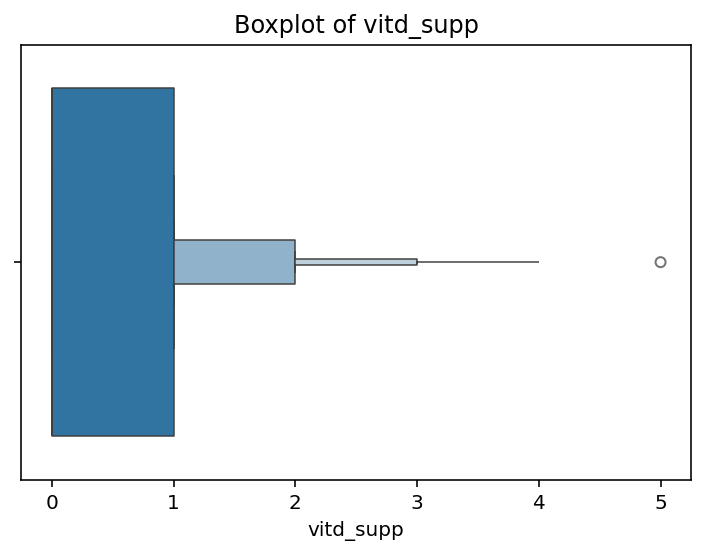

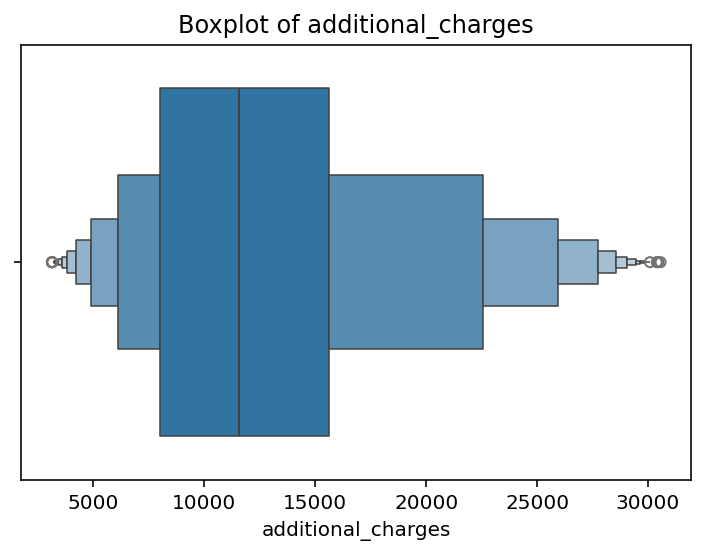

In [18]:
# Create a boxplot for each column with outliers
outlier_shape = rfr_data[["population", "children","income", "vitd_levels", "full_meals_eaten", "vitd_supp", "additional_charges"]]

for column in outlier_shape:
    sns.boxenplot(x=rfr_data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [19]:
##choose variable to treat outliers
## Winzorize the outliers
#from scipy.stats.mstats import winsorize
import warnings
## I am Sure that there are no NaN or partition errors
warnings.filterwarnings('ignore', message="Warning: 'partition' will ignore the 'mask' of the MaskedArray")

#Choose variables to winsorize - Population, income, VitD_levels, Full_meals_eaten
#Note that VitD levels will also need a lower limit calculation
#When using the limits, you are specifying "how much" to take off, not the "where" to take off

rfr_data['population_winz'] = winsorize(rfr_data['population'], limits=(0, 0.05))
rfr_data['income_winz'] = winsorize(rfr_data['income'], limits=(0, 0.05))
rfr_data['vitd_levels_winz'] = winsorize(rfr_data['vitd_levels'], limits=(0.05, 0.01))
rfr_data['full_meals_winz'] = winsorize(rfr_data['full_meals_eaten'], limits=(0, 0.05))

univariate(rfr_data)

,Type,Count,Missing,Unique,Mode,Min,Q1,Median,Q3,Max,Mean,Std,Skew,Kurt
Variable,,,,,,,,,,,,,,
totalcharge,float64,10000.0,0,9898,2330.57,1938.31,3179.375,5213.95,7459.7,9180.73,5312.172758,2180.393815,0.069661,-1.668267
population,int64,10000.0,0,5951,0,0.0,694.75,2769.0,13945.0,122814.0,9965.2538,14824.758614,2.229959,5.880913
children,int64,10000.0,0,11,0,0.0,0.0,1.0,3.0,10.0,2.0972,2.163659,1.448013,2.076321
age,int64,10000.0,0,72,47,18.0,36.0,53.0,71.0,89.0,53.5117,20.638538,0.005117,-1.189527
income,float64,10000.0,0,9993,14572.4,154.08,19598.775,33768.42,54296.4025,207249.1,40490.49516,28521.153293,1.405899,2.74569
vitd_levels,float64,10000.0,0,1060,18.52,9.81,16.6275,17.95,19.35,26.39,17.964272,2.017259,0.032469,-0.022453
doc_visits,int64,10000.0,0,9,5,1.0,4.0,5.0,6.0,9.0,5.0122,1.045734,-0.018563,0.025999
full_meals_eaten,int64,10000.0,0,8,0,0.0,0.0,1.0,2.0,7.0,1.0014,1.008117,1.009461,1.042727
vitd_supp,int64,10000.0,0,6,0,0.0,0.0,0.0,1.0,5.0,0.3989,0.628505,1.550205,2.330763


In [20]:
#Verify
print(rfr_data.columns)

Index(['totalcharge', 'population', 'children', 'age', 'income', 'vitd_levels',
       'doc_visits', 'full_meals_eaten', 'vitd_supp', 'initial_days',
       'additional_charges', 'gender', 'initial_admin', 'complication_risk',
       'highblood', 'diabetes', 'hyperlipidemia', 'services',
       'population_winz', 'income_winz', 'vitd_levels_winz',
       'full_meals_winz'],
      dtype='object')


In [21]:
#Remake data set with the outliers removed
rfr_data = rfr_data.drop(columns=["population", "income", "vitd_levels", "full_meals_eaten"], axis = 1)

#verify removal
print(rfr_data.columns)

Index(['totalcharge', 'children', 'age', 'doc_visits', 'vitd_supp',
       'initial_days', 'additional_charges', 'gender', 'initial_admin',
       'complication_risk', 'highblood', 'diabetes', 'hyperlipidemia',
       'services', 'population_winz', 'income_winz', 'vitd_levels_winz',
       'full_meals_winz'],
      dtype='object')


In [22]:
## Function for changing binary values to 0/1 
#AND creating dummy var WITH ALL VARIABLES KEPT

def wrangle_cat(df):
    #handle binary categorical variables
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]):
            # standardize the text format to lowercase
            df[col] = df[col].astype(str).str.strip().str.lower()
            # find binary columns with yes/ no or true/false
            if df[col].isin(['yes', 'no', 'true', 'false']).all():
                mapping = {'yes': 1, 'no': 0, 'true': 1, 'false': 0}
                df[col] = df[col].map(mapping)
    
    # one-hot encode the remaining categorical variables
    # Ensure to only encode those that haven't been converted to numeric in the previous step
    categorical_cols = df.columns[df.dtypes == 'object']
    df = pd.get_dummies(df, columns = categorical_cols, dtype = int, drop_first = False)
                
    return df


rfr_encoded = wrangle_cat(rfr_data)
print(rfr_encoded.columns)

Index(['totalcharge', 'children', 'age', 'doc_visits', 'vitd_supp',
       'initial_days', 'additional_charges', 'highblood', 'diabetes',
       'hyperlipidemia', 'population_winz', 'income_winz', 'vitd_levels_winz',
       'full_meals_winz', 'gender_female', 'gender_male', 'gender_nonbinary',
       'initial_admin_elective_admission', 'initial_admin_emergency_admission',
       'initial_admin_observation_admission', 'complication_risk_high',
       'complication_risk_low', 'complication_risk_medium',
       'services_blood_work', 'services_ct_scan', 'services_intravenous',
       'services_mri'],
      dtype='object')


In [23]:
#Verify encoding
rfr_encoded.head()

,totalcharge,children,age,doc_visits,vitd_supp,initial_days,additional_charges,highblood,diabetes,hyperlipidemia,...,initial_admin_elective_admission,initial_admin_emergency_admission,initial_admin_observation_admission,complication_risk_high,complication_risk_low,complication_risk_medium,services_blood_work,services_ct_scan,services_intravenous,services_mri
0,3726.70,1,53,6,0,10.59,17939.40,1,1,0,...,0,1,0,0,0,1,1,0,0,0
1,4193.19,3,51,4,1,15.13,17613.00,1,0,0,...,0,1,0,1,0,0,0,0,1,0
2,2434.23,3,53,4,0,4.77,17505.19,1,1,0,...,1,0,0,0,0,1,1,0,0,0
3,2127.83,0,78,4,0,1.71,12993.44,0,0,0,...,1,0,0,0,0,1,1,0,0,0
4,2113.07,1,22,5,2,1.25,3716.53,0,0,1,...,1,0,0,0,1,0,0,1,0,0


In [24]:
# Feature selection
X = rfr_encoded.drop(["totalcharge"], axis = 1)
y = rfr_encoded["totalcharge"]

#Select score_function basedon type of model build wanted.
#https://medium.com/@Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48

skbest = SelectKBest(score_func = f_regression, k ='all')  # Adjust 'k' based on feature selection strategy
X_new = skbest.fit_transform(X, y)
X_new.shape

p_values = pd.DataFrame({"Feature": X.columns, "p_value":skbest.pvalues_}).sort_values("p_value")
p_values[p_values["p_value"] < .05]

,Feature,p_value
4,initial_days,0.000000e+00
17,initial_admin_emergency_admission,7.524985e-27
19,complication_risk_high,3.842279e-17
21,complication_risk_medium,5.762875e-12
18,initial_admin_observation_admission,2.177258e-11
16,initial_admin_elective_admission,1.036366e-08
5,additional_charges,3.435248e-03
0,children,1.594917e-02
6,highblood,4.648892e-02


In [25]:
# Features to use for the rfr model
# "totalcharge","initial_days","initial_admin_emergency_admission", "complication_risk_high", "complication_risk_medium","initial_admin_observation_admission","initial_admin_elective_admission","additional_charges","children", "highblood"

rfr_features = rfr_encoded[[
    "totalcharge", "initial_days", "initial_admin_emergency_admission",
    "complication_risk_high", "complication_risk_medium",
    "initial_admin_observation_admission", "initial_admin_elective_admission",
    "additional_charges", "children", "highblood"
]].copy()
rfr_features.head()

,totalcharge,initial_days,initial_admin_emergency_admission,complication_risk_high,complication_risk_medium,initial_admin_observation_admission,initial_admin_elective_admission,additional_charges,children,highblood
0,3726.70,10.59,1,0,1,0,0,17939.40,1,1
1,4193.19,15.13,1,1,0,0,0,17613.00,3,1
2,2434.23,4.77,0,0,1,0,1,17505.19,3,1
3,2127.83,1.71,0,0,1,0,1,12993.44,0,0
4,2113.07,1.25,0,0,0,0,1,3716.53,1,0


In [26]:
# # DataFrame of rfr_encoded has been cleaned and is ready for use in the analysis model.
# # Export the data set as csv

# # Download clean data as csv
# rfr_features.to_csv('Forest_features_209.csv', index=False)

In [27]:
# Split the Data
# will split to 80% train, 20% test


X = rfr_features.drop(["totalcharge"], axis=1)
y = rfr_features["totalcharge"]

X_train, X_test, y_train, y_test = train_test_split( X, y,
    test_size=0.2,  # Specifies 20% of the data for testing
    random_state=42,  # Ensures reproducibility
)

In [28]:
# Standardize the values using scale

scale = StandardScaler()

X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scale.transform(X_test), columns=X_test.columns)

# Concatenate scaled features with the target variable
train_data = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1)

# Display the head of the training data
train_data.head()

,initial_days,initial_admin_emergency_admission,complication_risk_high,complication_risk_medium,initial_admin_observation_admission,initial_admin_elective_admission,additional_charges,children,highblood,totalcharge
0,1.085707,0.983880,-0.707969,-0.914630,-0.565995,-0.576196,-0.768628,1.811886,-0.827170,7749.51
1,-0.720801,-1.016384,-0.707969,-0.914630,1.766801,-0.576196,0.820278,-0.504585,1.208941,3303.45
2,-1.159237,-1.016384,-0.707969,1.093339,-0.565995,1.735522,-0.567303,-0.967879,-0.827170,2330.57
3,1.109243,0.983880,-0.707969,1.093339,-0.565995,-0.576196,-0.557325,-0.041291,-0.827170,7980.62
4,0.887557,0.983880,-0.707969,1.093339,-0.565995,-0.576196,-1.229573,-0.967879,-0.827170,7284.53


In [29]:
test_data.head()

,initial_days,initial_admin_emergency_admission,complication_risk_high,complication_risk_medium,initial_admin_observation_admission,initial_admin_elective_admission,additional_charges,children,highblood,totalcharge
0,0.534151,-1.016384,-0.707969,1.093339,-0.565995,1.735522,-0.255714,-0.504585,-0.827170,6060.70
1,-0.854040,-1.016384,-0.707969,1.093339,1.766801,-0.576196,0.925850,-0.504585,1.208941,3255.81
2,-1.168727,-1.016384,1.412492,-0.914630,-0.565995,1.735522,1.835249,-0.504585,1.208941,2844.70
3,-0.833162,-1.016384,-0.707969,-0.914630,-0.565995,1.735522,1.805497,-0.041291,1.208941,3133.94
4,-0.676388,0.983880,-0.707969,-0.914630,-0.565995,-0.576196,-0.597966,-0.967879,-0.827170,4125.01


In [30]:
# #Export testing and training files

# X_train_scaled.to_csv("X_train_209.csv", index=False)
# X_test_scaled.to_csv("X_test_209.csv", index = False)
# y_train.to_csv("Y_train_209.csv", index = False)
# y_test.to_csv("Y_test_209.csv", index = False)

In [31]:
## Random forest w/ scaled data
# Initialize and build Random forest model

rfr = RandomForestRegressor(
    n_estimators=100,  # More trees for better generalization
    max_features="sqrt",  # Square root of the number of features for a regression task
    random_state=42
)
rfr.fit(X_train_scaled, y_train)
y_pred = rfr.predict(X_test_scaled)

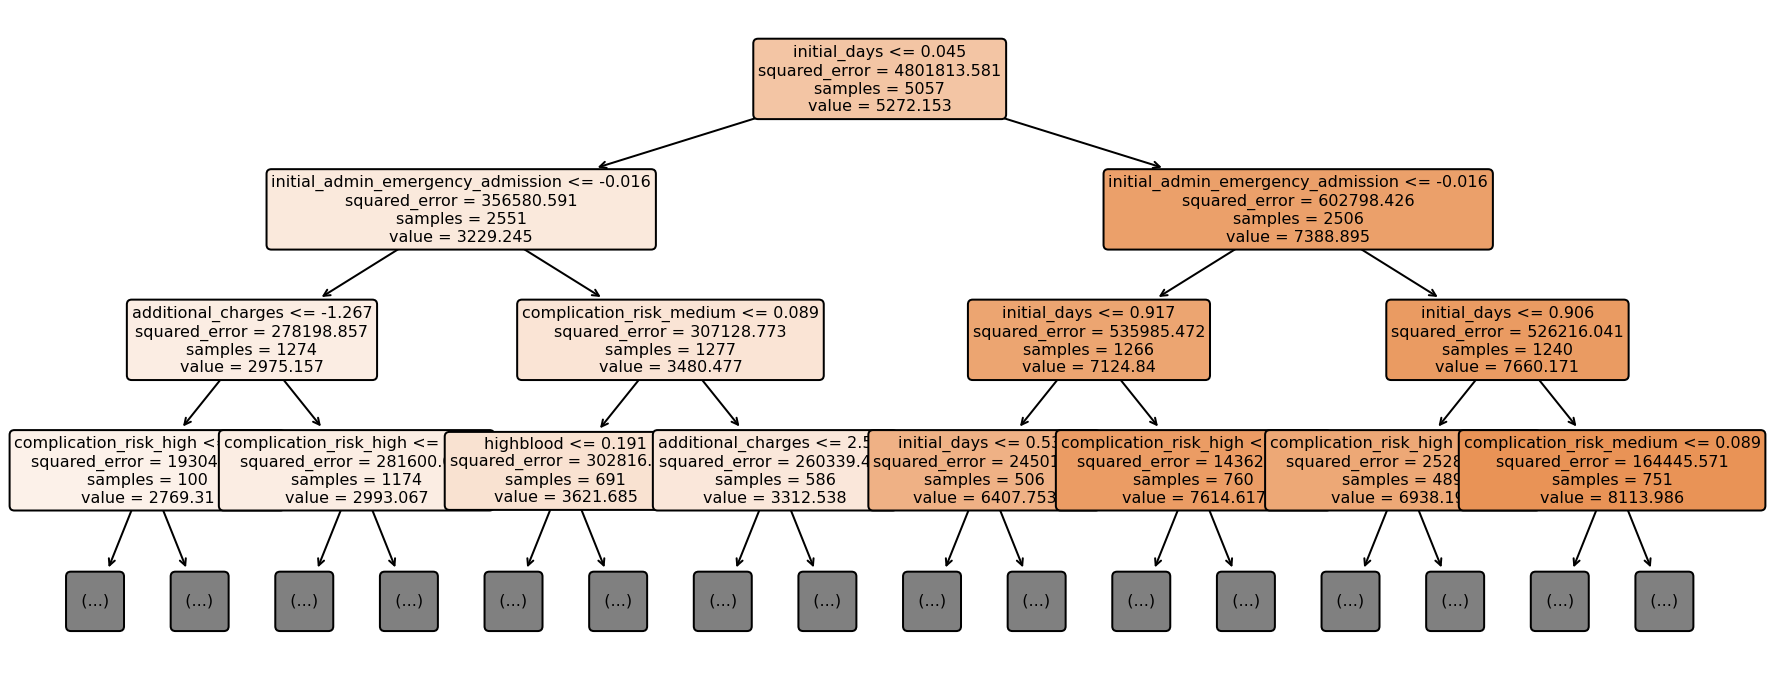

In [33]:
##A visualization for my own curiosity

features = X.columns
# Obtain just the first tree
first_tree = rfr.estimators_[0]

plt.figure(figsize=(15,6))
tree.plot_tree(first_tree,
               feature_names=features,
               fontsize=8, 
               filled=True, 
               rounded=True,
               max_depth = 3);

In [34]:
#Evaluation metrics
mse = mean_squared_error(y_test, y_pred).round(2)
rmse = root_mean_squared_error(y_test, y_pred).round(2)

# View accuracy score

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred).round(2))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2_score(y_test, y_pred).round(4))

Mean Absolute Error: 98.18
Mean Squared Error: 15721.45
Root Mean Squared Error: 125.39
R² Score: 0.9967


In [35]:
#Evaluate the out of bag score - OOB
#https://cnvrg.io/random-forest-regression/
# should be greater than 0.75

random_forest_out_of_bag = RandomForestRegressor(oob_score=True)
random_forest_out_of_bag.fit(X_train, y_train)
print(random_forest_out_of_bag.oob_score_.round(4))

0.9976


### Hyperparameter tuning with GridsearchCV 



In [36]:
# Create a parameter grid
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [37]:
# Set up the grid search
grid_search = GridSearchCV(estimator = rfr,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1,
                           scoring= 'neg_mean_squared_error')

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


Best parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 17151.511355670198


In [0]:
# Best parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
# Best score: 17151.511355670198

### Final Tuned Model

In [38]:
rfr_final = RandomForestRegressor(
    n_estimators = 200,  
    max_features="log2",
    max_depth = 30,
    min_samples_leaf = 1,
    min_samples_split = 2,
    random_state=42
)

rfr_final.fit(X_train, y_train)

y_pred = rfr_final.predict(X_test)


In [39]:
#Evaluation metrics
mse = mean_squared_error(y_test, y_pred).round(2)
rmse = root_mean_squared_error(y_test, y_pred).round(2)

# View accuracy score

print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred).round(2))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2_score(y_test, y_pred).round(4))

Mean Absolute Error: 96.35
Mean Squared Error: 15093.73
Root Mean Squared Error: 122.86
R² Score: 0.9968


In [0]:
#Initial Model values
# Mean Absolute Error: 98.02503004999996
# Mean Squared Error: 15671.057752168708
# R² Score: 0.9966708568041508